In [1]:
# load your csv file into dataframe
# data processing and calculation tools
import pandas as pd
import numpy as np
# Specify the path to your CSV file
csv_file_path = '/home/zelim/Desktop/cqa_code/cqa_day1/merged_btc_sopr_ratio_1d_candles.csv'
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)
df
df['price_chg'] = df['close'].pct_change()

<Axes: >

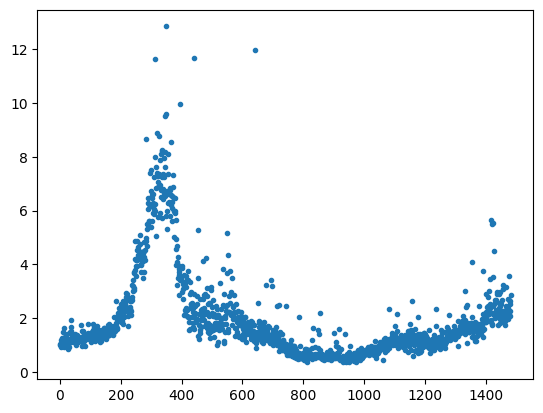

In [9]:
df['sopr_ratio'].plot(style=".")

In [3]:
def backtesting(rolling_window, z_score_threshold, sr_multiplier, fees, backtest_mode):
    # z_score calculation
    # rolling mean
    df['sma'] = df['sopr_ratio'].rolling(window=rolling_window).mean()
    # rolling std
    df['rolling_std'] = df['sopr_ratio'].rolling(window=rolling_window).std()
    # zscore = (closeprice - mean) / std
    df['z_score'] = (df['sopr_ratio'] - df['sma']) / df['rolling_std']
    # convert zscore into array and convert NaN to 0.0
    not_clean_z_score = df["z_score"].values
    z_score = np.nan_to_num(not_clean_z_score)
    position = np.array([0.0] * len(df))

    # position entry exit logic
    long_trade = 0
    short_trade = 0
    # loopp all the zscore for entry and exit based on z_score
    if backtest_mode == "trend":
        for i in range(1, len(position)):
            if z_score[i] >= z_score_threshold:
                position[i] = 1
                # previous position = 0 or -1 , current position = 1
                if position[i-1] != position[i]:
                    long_trade += 1
            elif z_score[i] <= z_score_threshold * -1.0: # 1 * -1.0 = -1
                position[i] = -1
                # previous position = 1 or 0, current position = -1
                if position[i-1] != position[i]:
                    short_trade += 1
            else:
                position[i] = position[i-1] # previous position = 1, current position = 1
    else:
        for i in range(1, len(position)):
            if z_score[i] >= z_score_threshold:
                position[i] = -1
                # previous position = 1 or 0, current position = -1
                if position[i-1] != position[i]:
                    short_trade += 1
            elif z_score[i] <= z_score_threshold * -1.0: # 1 * -1.0 = -1
                position[i] = 1
                # previous position = 0 or -1 , current position = 1
                if position[i-1] != position[i]:
                    long_trade += 1
            else:
                position[i] = position[i-1] # previous position = 1, current position = 1


    # trades and pnl calculation
    # After done entry and exit logic
    # Calculate performance 
    interval_pnl = [0]
    trades = [0]
    # get the trades
    for i in range(1,len(df)):
        # if previous position is not same as current position , mean got trade executed
        # example, previous position = 0, current position = -1 , trades = 0 - (-1) = 1
        # previous position = 0, current position = 1 , trades = 0 - 1 = abs(-1) = 1
        # previous position = 1, current position = -1 , trades = 1 - (-1) = abs(2) = 2
        # previous position = -1, current position = 1 , trades = -1 - 1 = abs(-2) = 2
        if position[i-1] != position[i]:
            trades.append(abs(position[i-1] - position[i]))
        else:
            trades.append(0)
    # calculate the PnL by using trades and position, and also fees 
    price_change = df['price_chg'].values
    for i in range(1,len(df)):
        interval_pnl.append(position[i-1] * price_change[i] - trades[i] * fees / 100)
    df['pnl'] = interval_pnl
    df['position'] = position
    df['trade'] = trades
    df['cumu'] = df['pnl'].cumsum()


    # performance report
    mdd = min(interval_pnl)
    # mean of PnL
    mean = np.mean(interval_pnl)
    # standard deviation of PnL
    stddev = np.std(interval_pnl)

    # SR multiplier => daily data = 365 * 1
    #                  1 hour data = 365 * 24
    # Sharpe ratio = mean of pnl / std of pnl * square root of (365 * sr_multiplier)
    sharpe_ratio = mean / stddev * np.sqrt(365 * sr_multiplier)
    # Performance report
    data = {
            'rolling_window': rolling_window,
            'z_score_threshold': z_score_threshold,
            'num_of_trades': np.sum(trades),
            'long_trades': long_trade,
            'short_trades': short_trade,
            'cumu': df['cumu'].iat[-1],
            'AR': mean * 365 * sr_multiplier,
            'MDD': mdd,
            'CR': mean * 365 * sr_multiplier / abs(mdd),
            'SR': sharpe_ratio 
        }

    return data

trend


/tmp/ipykernel_132029/993617676.py:84: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = mean / stddev * np.sqrt(365 * sr_multiplier)
/tmp/ipykernel_132029/993617676.py:95: RuntimeWarning: invalid value encountered in scalar divide
  'CR': mean * 365 * sr_multiplier / abs(mdd),


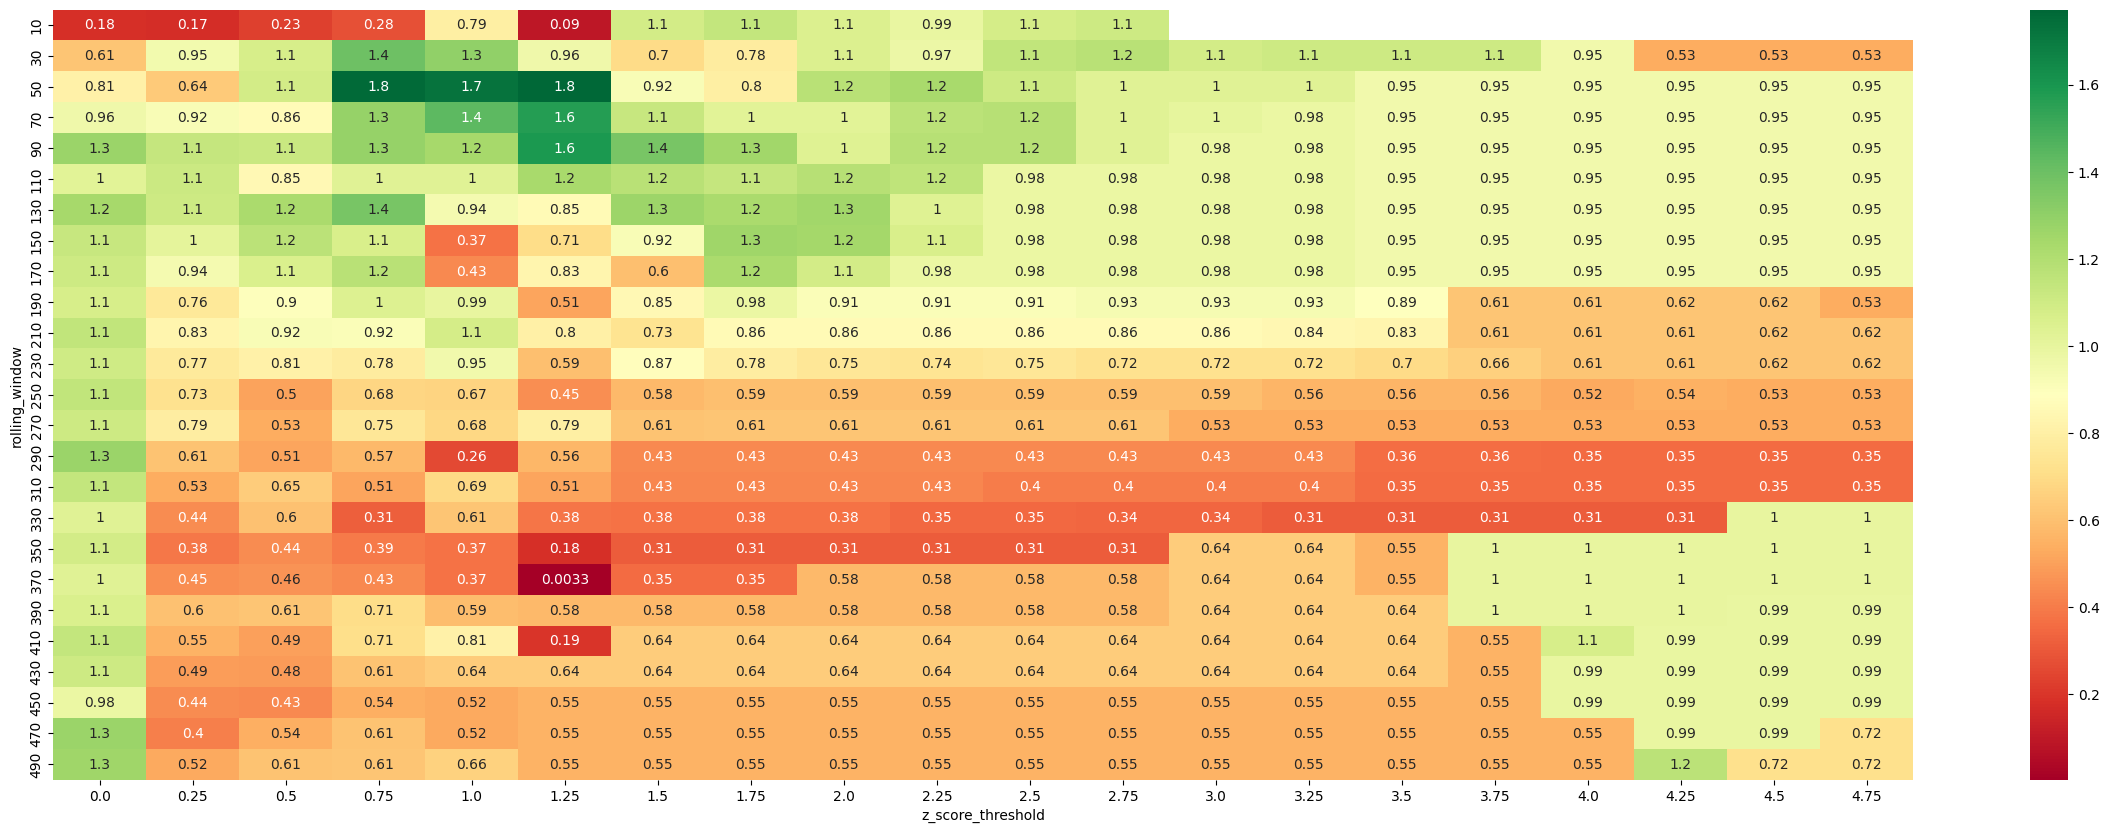

mr


/tmp/ipykernel_132029/993617676.py:84: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = mean / stddev * np.sqrt(365 * sr_multiplier)
/tmp/ipykernel_132029/993617676.py:95: RuntimeWarning: invalid value encountered in scalar divide
  'CR': mean * 365 * sr_multiplier / abs(mdd),


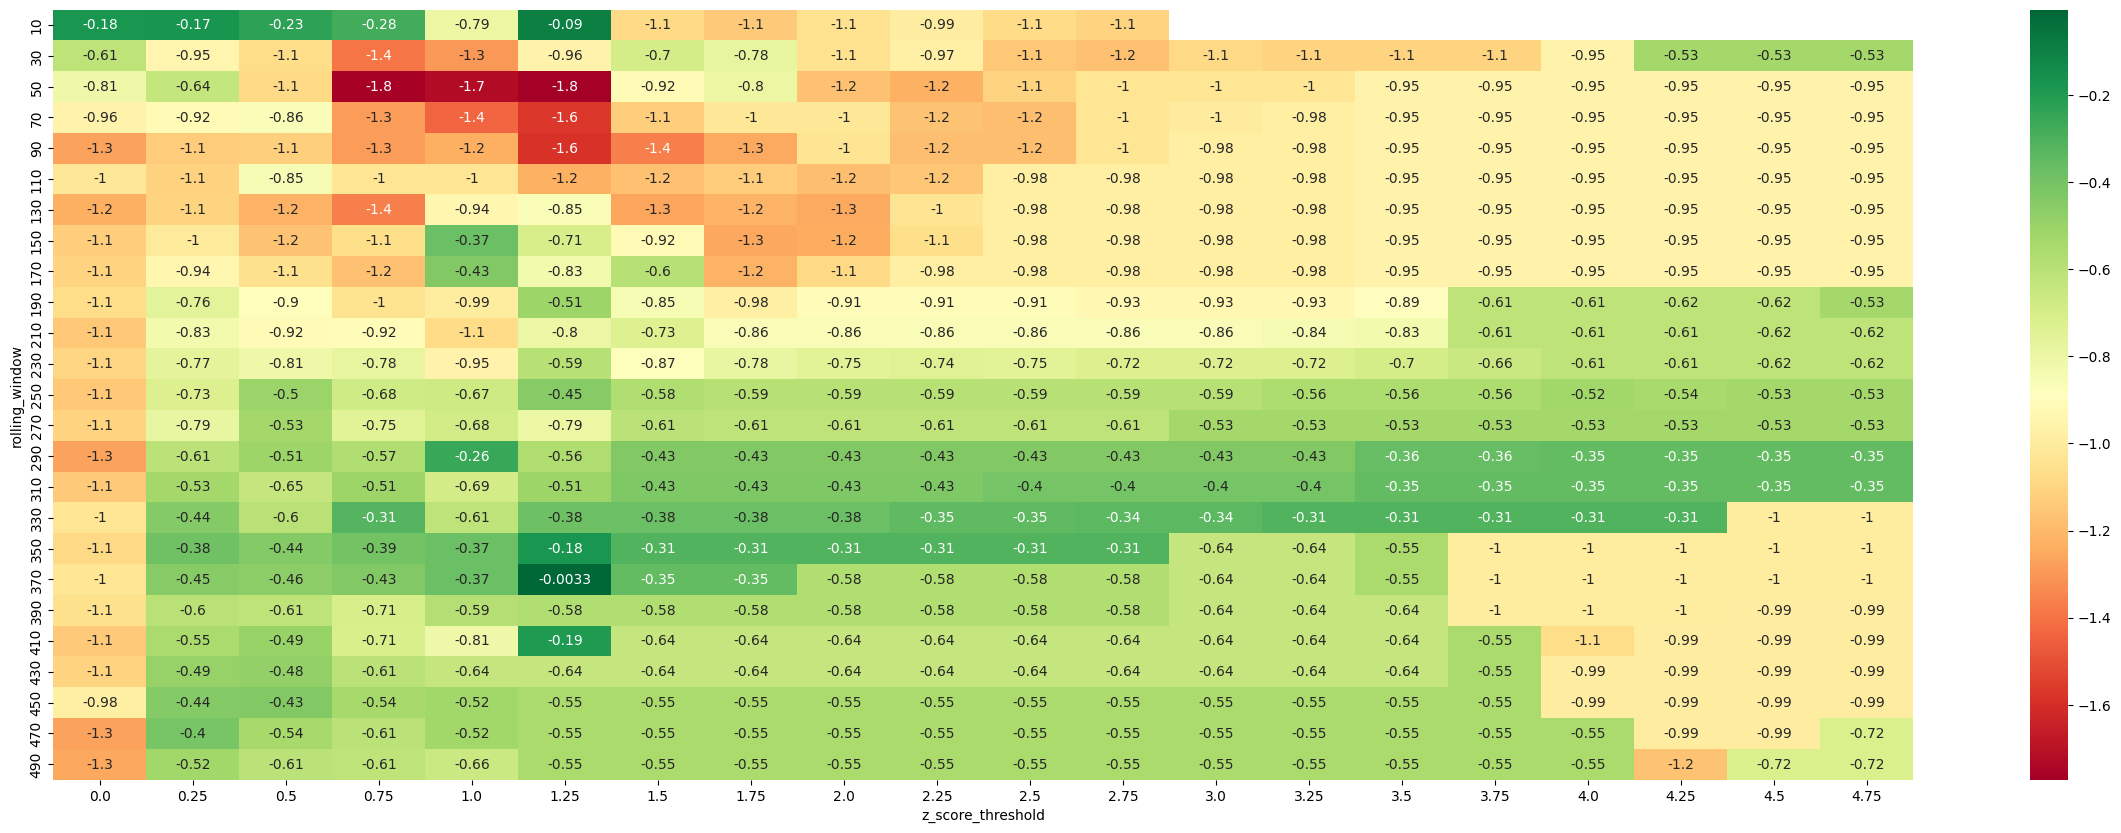

In [7]:
# loop all params needed to backtest 
rolling_window_array = np.arange(10, 500, 20)
z_score_threshold_array = np.arange(0, 5, 0.25)
backtest_mode_arr = ["trend", "mr"]
for backtest_mode in backtest_mode_arr:
    print(backtest_mode)
    all_result = []
    for rolling_window in rolling_window_array:
        for z_score_threshold in z_score_threshold_array:
            backtest_1 = backtesting(rolling_window=rolling_window, z_score_threshold=z_score_threshold, sr_multiplier=1, fees=0.0, backtest_mode=backtest_mode)
            # print(backtest_1)
            all_result.append(backtest_1)
    all_sr = pd.DataFrame(all_result)
    df_pivot = all_sr.pivot(index="rolling_window",columns ='z_score_threshold', values="SR")
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Create a heatmap
    plt.figure(figsize=(30, 10))
    sns.heatmap(df_pivot,annot=True, cmap='RdYlGn')
    # Show the plot
    plt.show()

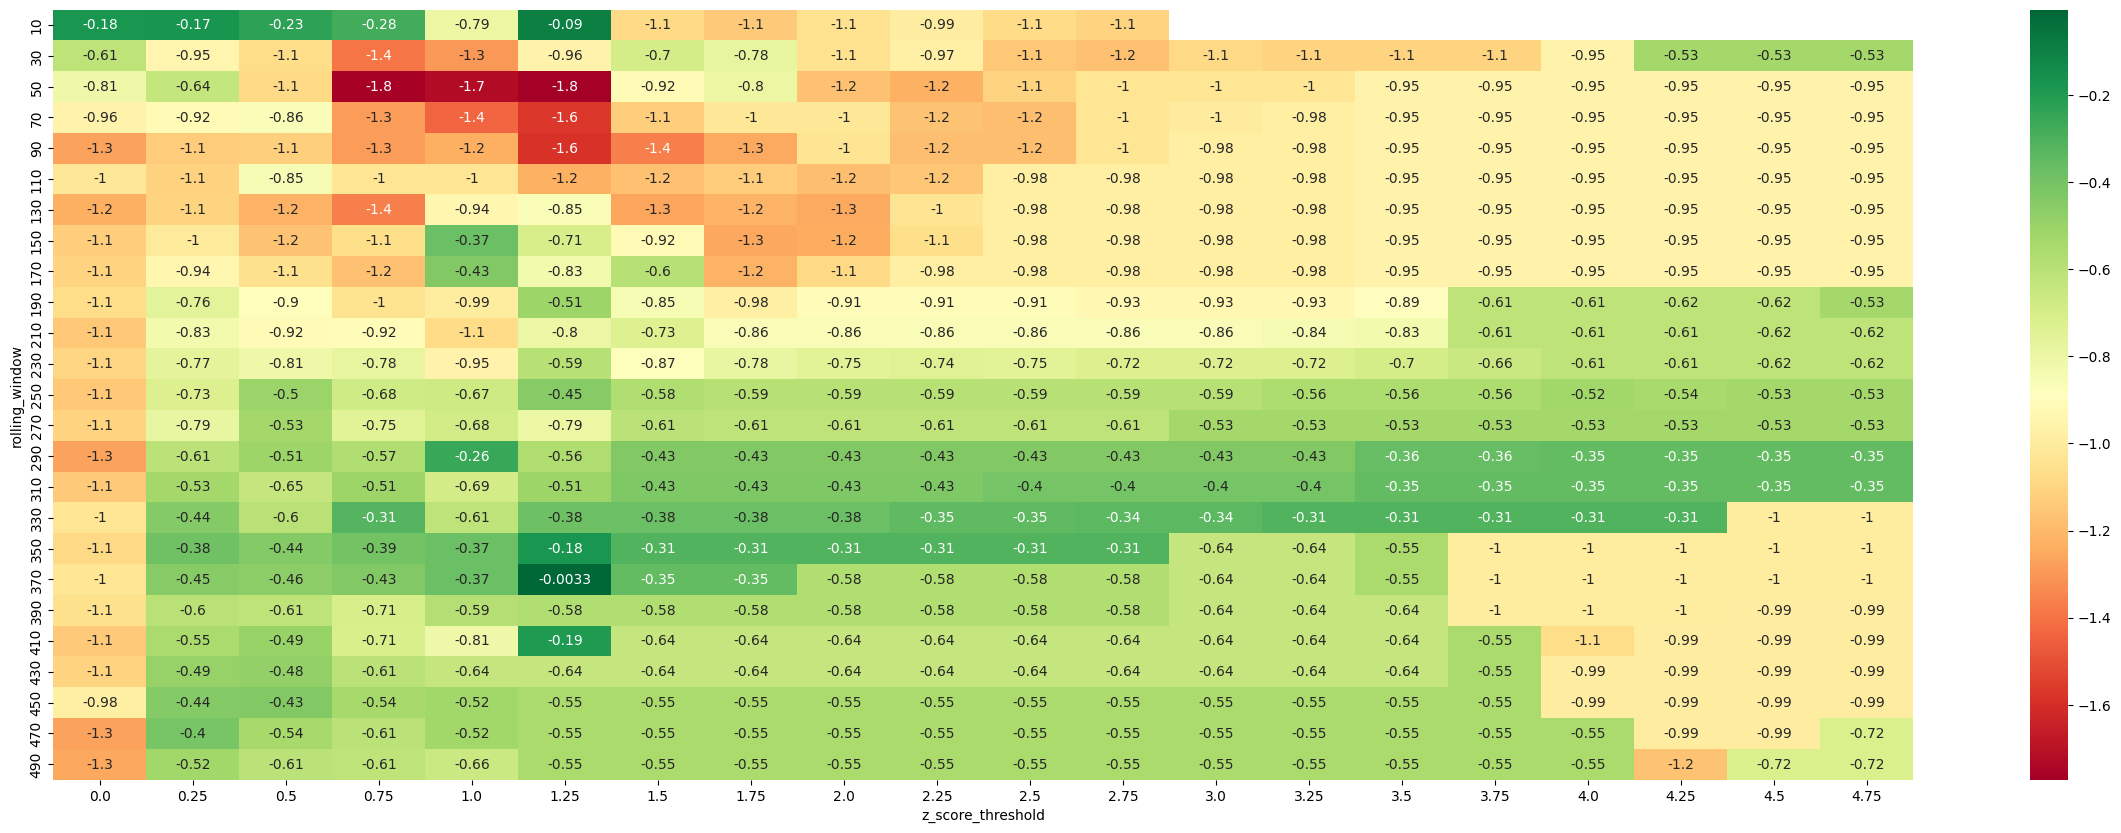

In [5]:
all_sr = pd.DataFrame(all_result)
df_pivot = all_sr.pivot(index="rolling_window",columns ='z_score_threshold', values="SR")
import matplotlib.pyplot as plt
import seaborn as sns
# Create a heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(df_pivot,annot=True, cmap='RdYlGn')
# Show the plot
plt.show()

In [ ]:
backtest_1 = backtesting(rolling_window=50,z_score_threshold=1,sr_multiplier=1,fees=0)
print(backtest_1)